In [ ]:
import numpy as np
from tqdm import tqdm, trange
import matplotlib.pyplot as plt
import math
import matplotlib.font_manager as fm

In [ ]:
from utils.plot_fig import plot_lr_all_info, plot_static_semilogy
from utils.doubly_random_matrix import get_strongly_connected_directed_row_column_stochastic_matrix
from utils.stepsize_alg import get_stepsize, get_beta1t
from utils.load_logistic_regression_data import (
    load_mnist_data,
    load_covtype_data,
    load_cifar10_data,
    load_fashion_mnist_data,
    load_breast_cancer_data,
)
from utils.random_quantizer import probabilistic_quantizer, stochastic_k_level_quantizer
from utils.summary_writer import get_summary_writer
from utils.model_metrics import get_scores
from utils.data_recorder import LRTrainingRecorder

# 0 预备

In [ ]:
# 设置字体优先级：中文用宋体，英文用 Times New Roman

plt.rcParams['font.sans-serif'] = ['Times New Roman']  # ✅ 宋体+Times New Roman
plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示异常

# 指定中英文字体路径
chinese_font_path = 'C:/Windows/Fonts/simsun.ttc'  # 替换为你的宋体路径
english_font_path = 'C:/Windows/Fonts/times.ttf'   # 替换为 Times New Roman 路径

chinese_font = fm.FontProperties(fname=chinese_font_path)
english_font = fm.FontProperties(fname=english_font_path)

# 1 导入数据

In [ ]:
data_name="covtype"

In [ ]:
if data_name=="mnist":
    mnist_path = r".\data\mnist\6000_data_0.001.mat"
    (
        x_train,
        y_train,
        x_test,
        y_test,
        w_opt,
        lambda_val,
        dims,
        cls_nums,
        nums,
    ) = load_mnist_data(mnist_path)
elif data_name=="fashion-mnist":
    fashion_mnist_path=r".\data\fashion_mnist"
    (
        x_train,
        y_train,
        x_test,
        y_test,
        w_opt,
        lambda_val,
        dims,
        cls_nums,
        nums,
    ) = load_fashion_mnist_data(fashion_mnist_path)
elif data_name=="cifar10":
    cifar_10_path=r"data\cifar-10\cifar-10-batches-py"
    ( 
        x_train,
        y_train,
        x_test,
        y_test,
        w_opt,
        dims,
        cls_nums,
        nums
      ) = load_cifar10_data(cifar_10_path)
elif data_name=="covtype":
    (x_train,
     y_train,
     x_test,
     y_test,
     w_opt,
     dims,
     cls_nums,
     nums)=load_covtype_data(covtype_path="~/scikit_learn_data", test_size=0.2)


In [ ]:
print((dims, nums))

(54, 464809)


In [ ]:
x_train.shape

(54, 464809)

In [ ]:
y_train.shape

(7, 464809)

In [ ]:
cls_nums

7

In [ ]:
x_test.shape

(54, 116203)

## 1.2 导入算法

In [ ]:
alg_table={
    "q-pdq":True,
    "q-dadam-ps":True,
    "kq-dadam-ps": False,
    "dadam-ps":True
}

# 2 初始化

## 2.1 初始化模型参数

In [ ]:
np.random.seed(42)

In [ ]:
w_init = np.random.randn(dims, cls_nums if cls_nums > 2 else 1)

In [ ]:
w_init.shape

(54, 7)

In [ ]:
epsilon = 1e-5

In [ ]:
# 最大迭代次数
epoch_num = 300

In [ ]:
agents_num = 10

In [ ]:
y_train.shape

(7, 464809)

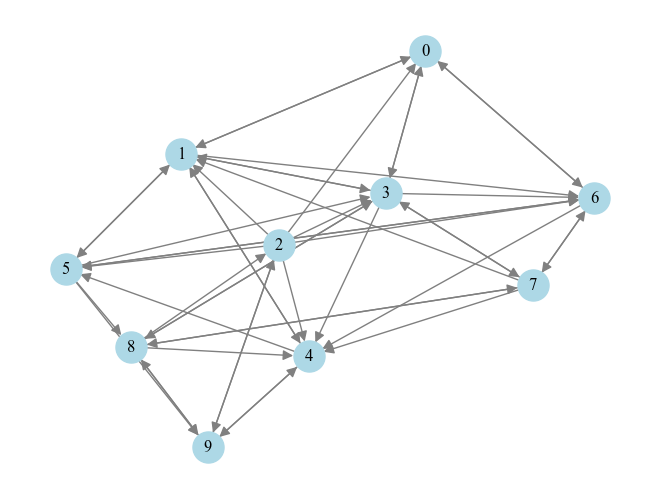

In [ ]:
R,C = get_strongly_connected_directed_row_column_stochastic_matrix(agents_num,show=True)
net = C.T

## 2.2 设置损失函数

In [ ]:
def softmax(scores):
    max_scores = np.max(scores, axis=0, keepdims=True)
    shifted_scores = scores - max_scores
    exp_scores = np.exp(shifted_scores)
    sum_exp_scores = np.sum(exp_scores, axis=0, keepdims=True)
    return exp_scores / sum_exp_scores

In [ ]:
def loss_fn(x, y, w):
    samples_num = y.shape[1]
    scores = np.dot(w.T, x)
    predictions = softmax(scores)
    loss = -np.sum(y * np.log(predictions + epsilon)) / samples_num
    return loss

In [ ]:
y_train[:,0]

array([1., 0., 0., 0., 0., 0., 0.])

In [ ]:
def grad_fn(x, y, w):
    samples_num = y.shape[1]
    scores = np.dot(w.T, x)
    predictions = softmax(scores)
    output_error = predictions - y

    return np.dot(x, output_error.T) / samples_num

In [ ]:
def predict(w, x):
    scores = np.dot(w.T, x)
    predictions = softmax(scores)
    predicted = np.argmax(predictions, axis=0)
    return predicted

In [ ]:
quantizer=probabilistic_quantizer

## 2.3 初始化LRTrainingRecorder和SummaryWriter

In [ ]:
training_recorder=LRTrainingRecorder(is_binary=False)

In [ ]:
writer = get_summary_writer(f"./logs/qdadamPS_compare_multi_logistic_regression/{data_name}")
# pic_save_path = "./results/dadam_batch_size_1000"

# 3 Quantized Push-Sum模型训练

## 3.1 设置优化器初始参数

In [ ]:

# 初始步长
step_init = 1
# eig返回元组，第一为特征值，第二为特征向量
# step_init=1-np.sort(np.linalg.eig(net)[0])[1]  # 选取第二特征值


In [ ]:
# 批量大小
batch_size = 100
sample_nums_per_agent=math.ceil(nums/agents_num)

In [ ]:
beta1t_lambda=0.9

## 3.2 初始化优化器

In [ ]:
w_node = np.zeros((agents_num, dims, cls_nums if cls_nums > 2 else 1))
quanz_node=np.zeros((agents_num, dims, cls_nums if cls_nums > 2 else 1))

x_node=np.zeros((agents_num, dims, cls_nums if cls_nums > 2 else 1))
x_prev_node=np.zeros((agents_num, dims, cls_nums if cls_nums > 2 else 1))
# x_hat_node 初始化为0
x_hat_node=np.zeros((agents_num, dims, cls_nums if cls_nums > 2 else 1))
x_hat_prev_node=np.zeros((agents_num, dims, cls_nums if cls_nums > 2 else 1))
# y_node 初始化为1
y_node=np.ones((agents_num, dims, cls_nums if cls_nums > 2 else 1))
y_prev_node=np.ones((agents_num, dims, cls_nums if cls_nums > 2 else 1))
z_node=np.zeros((agents_num, dims, cls_nums if cls_nums > 2 else 1))


In [ ]:
for ii in range(agents_num):
    w_node[ii] = w_init.copy()
    quanz_node[ii]=quantizer(w_init,1)

    x_node[ii]=w_init.copy()
    x_prev_node[ii]=w_init.copy()

    z_node[ii]=w_init.copy()

In [ ]:
batch_nums = math.ceil(nums / (batch_size*agents_num))

In [ ]:
total_iter = 0

In [ ]:
kt_pow=1.5

## 3.3 模型训练

In [ ]:
# 算法名称
alg_name="q-pdq"
if alg_table[alg_name]:
    alg_label = f"method_{alg_name}_step_{step_init:.2f}_bs_{batch_size}_ktpow_{kt_pow}"

    
    # 初始化 训练过程记录
    training_recorder.init_alg_model(alg_label)
    # 记录初始状态
    training_recorder.auto_cal_and_append(alg_label,np.mean(w_node,axis=0),w_opt,loss_fn,get_scores,predict,x_train,y_train,x_test,y_test)

    pbar=tqdm(total=epoch_num)
    for i in trange(epoch_num):
        pbar.update()
        for j in range(batch_nums):
            total_iter = total_iter + 1
            kt=math.ceil((i+1)**kt_pow)
            
            step=get_stepsize(step_init,total_iter,method="decay-sq")
            for ii in range(agents_num):
                start = ii * sample_nums_per_agent
                end = min((ii + 1) * sample_nums_per_agent, nums)
                # 获取数据切片
                x_data = x_train[:, start:end]
                y_data = y_train[:, start:end]

                # 生成随机数
                random_index=np.random.randint(0,end-start,size=batch_size)
                
                linear_index=list(range(0,end-start))[batch_size*j:batch_size*(j+1)]
                x_data=x_data[:,random_index]
                y_data=y_data[:,random_index]
                # 对权重进行量化
                quanz_node[ii]=quantizer(x_prev_node[ii]-x_hat_prev_node[ii],kt,use_quantize=True)
                x_hat_node[ii]=x_hat_prev_node[ii]+quanz_node[ii]

                w_consen_node = x_prev_node[ii]-x_hat_node[ii]
                for jj in range(agents_num):
                    w_consen_node = w_consen_node + net[ii, jj] * x_hat_node[jj]
                w_node[ii] = w_consen_node

                y_consen_node=np.zeros(w_init.shape)
                for jj in range(agents_num):
                    y_consen_node=y_consen_node+net[ii,jj]*y_prev_node[ii]
                y_node[ii]=y_consen_node

                z_node[ii]=w_node[ii]/y_node[ii]
                
                # 梯度下降函数更新W权重
                grad = grad_fn(x_data, y_data, z_node[ii].squeeze())
                x_node[ii]=w_node[ii]-step*grad
                
                x_prev_node[ii]=x_node[ii].copy()
                x_hat_prev_node[ii]=x_hat_node[ii].copy()
                y_prev_node[ii]=y_node[ii].copy()
                

            w = np.mean(z_node,axis=0)


        # 记录训练过程各参数
        training_recorder.auto_cal_and_append(alg_label,w,w_opt,loss_fn,get_scores,predict,x_train,y_train,x_test,y_test)
        pbar.set_postfix(loss=training_recorder.get_data_by_measure_and_alg_label('loss',alg_label)[i],
                         accu=training_recorder.get_data_by_measure_and_alg_label('accu',alg_label)[i],
                         gen=i+1)
    


100%|██████████| 300/300 [24:42<00:00,  4.94s/it] accu=0.624, gen=300, loss=4.33]


## 3.4 展示结果

              precision    recall  f1-score   support

           0  0.65138257 0.08745917 0.15421267     42557
           1  0.53478047 0.96364602 0.68784031     56500
           2  0.63251784 0.34854655 0.44943413      7121
           3  0.00000000 0.00000000 0.00000000       526
           4  0.00000000 0.00000000 0.00000000      1995
           5  0.22222222 0.00057323 0.00114351      3489
           6  0.16987519 0.20000000 0.18371082      4015

    accuracy                      0.52885898    116203
   macro avg  0.31582547 0.22860357 0.21090592    116203
weighted avg  0.54987846 0.52885898 0.42484115    116203

Confusion matrix, without normalization
[[ 3722 35838     0     0     0     0  2997]
 [  889 54446   269    12     0     6   878]
 [    2  4624  2482     5     0     1     7]
 [    0   107   419     0     0     0     0]
 [    5  1949     0     0     0     0    41]
 [    3  2727   754     2     0     2     1]
 [ 1093  2119     0     0     0     0   803]]


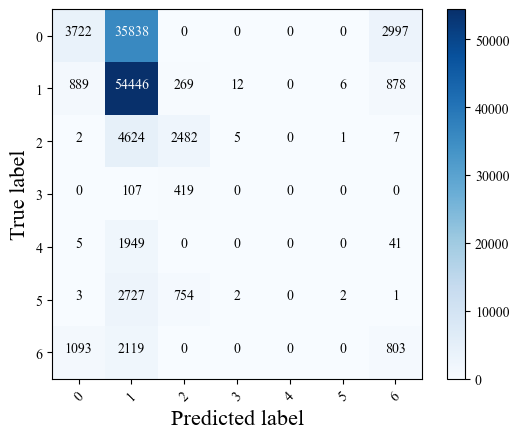

In [ ]:
if alg_table[alg_name]:
    # 展示模型的混淆矩阵及其数据
    predicted = predict(w, x_test).squeeze()
    plot_lr_all_info(np.argmax(y_test, axis=0), predicted, classes=list(range(cls_nums)))

# 4 DADAM-Push-Sum模型训练

## 4.1 设置优化器初始参数

In [ ]:

# 初始步长

step_init = 1
# eig返回元组，第一为特征值，第二为特征向量
# step_init=1-np.sort(np.linalg.eig(net)[0])[1]  # 选取第二特征值
beta1 = 0.9
beta2 = 0.999
beta3 = 0.9
G0=1e-3
beta1t_lambda=0.9

In [ ]:
# 批量大小
batch_size = 1000
sample_nums_per_agent=math.ceil(nums/agents_num)

In [ ]:
beta1t_lambda=0.9

## 4.2 初始化优化器

In [ ]:
w_node = np.zeros((agents_num, dims, cls_nums if cls_nums > 2 else 1))
x_node = np.zeros((agents_num, dims, cls_nums if cls_nums > 2 else 1))
x_prev_node=np.zeros((agents_num, dims, cls_nums if cls_nums > 2 else 1))
# x_hat_node 初始化为0
quant_x_node=np.zeros((agents_num, dims, cls_nums if cls_nums > 2 else 1))
quant_x_prev_node=np.zeros((agents_num, dims, cls_nums if cls_nums > 2 else 1))
m_node = np.zeros((agents_num, dims, cls_nums if cls_nums > 2 else 1))
v_node = np.zeros((agents_num, dims, cls_nums if cls_nums > 2 else 1))
m_hat_node = np.zeros((agents_num, dims, cls_nums if cls_nums > 2 else 1))
v_hat_node = np.zeros((agents_num, dims, cls_nums if cls_nums > 2 else 1))
v_bar_node = np.zeros((agents_num, dims, cls_nums if cls_nums > 2 else 1))
v_bar_prev_node = G0**2 * np.ones((agents_num, dims, cls_nums if cls_nums > 2 else 1))


x_hat_node=np.zeros((agents_num, dims, cls_nums if cls_nums > 2 else 1))
x_hat_prev_node=np.zeros((agents_num, dims, cls_nums if cls_nums > 2 else 1))
# y_node 初始化为1
y_node=np.ones((agents_num, dims, cls_nums if cls_nums > 2 else 1))
y_prev_node=np.ones((agents_num, dims, cls_nums if cls_nums > 2 else 1))

z_node=np.zeros((agents_num, dims, cls_nums if cls_nums > 2 else 1))


In [ ]:
for ii in range(agents_num):
    w_node[ii] = w_init.copy()
    quant_x_node[ii]=quantizer(w_init,1)

    x_node[ii]=w_init.copy()
    x_prev_node[ii]=w_init.copy()

    z_node[ii]=w_init.copy()

In [ ]:
batch_nums = math.ceil(nums / (batch_size*agents_num))

In [ ]:
total_iter = 0

In [ ]:
kt_pow=1.5

## 4.3 模型训练

In [ ]:
# 算法名称
alg_name="dadam-ps"
record_w=[np.average(w_node[1])]
record_y=[np.average(y_node[1])]
record_accuracy_ls=[]
record_loss_ls=[]
if alg_table[alg_name]:
    
    alg_label = f"method_{alg_name}_step_{step_init:.2f}_bs_{batch_size}_ktpow_{kt_pow}"
    # 初始化 训练过程记录
    training_recorder.init_alg_model(alg_label)
    # 记录初始状态
    training_recorder.auto_cal_and_append(alg_label,np.mean(w_node,axis=0),w_opt,loss_fn,get_scores,predict,x_train,y_train,x_test,y_test)


    pbar=tqdm(total=epoch_num)
    for i in trange(epoch_num):
        pbar.update()
        # _,net = get_strongly_connected_directed_row_column_stochastic_matrix(agents_num)
        for j in range(batch_nums):
            total_iter = total_iter + 1
            kt=math.ceil((i+1)**kt_pow)
            beta1t=get_beta1t(beta1,total_iter,lambda_val=beta1t_lambda)
            step=get_stepsize(step_init,total_iter,method="decay-sq")
            for ii in range(agents_num):
                start = ii * sample_nums_per_agent
                end = min((ii + 1) * sample_nums_per_agent, nums)
                # 获取数据切片
                x_data = x_train[:, start:end]
                y_data = y_train[:, start:end]

                # 生成随机数
                random_index=np.random.randint(0,end-start,size=batch_size)
                
                linear_index=list(range(0,end-start))[batch_size*j:batch_size*(j+1)]
                x_data=x_data[:,random_index]
                y_data=y_data[:,random_index]
                # 对权重进行量化
                w_consen_node = np.zeros(w_init.shape)
                for jj in range(agents_num):
                    w_consen_node = w_consen_node + net[ii,jj] * x_prev_node[jj]
                w_node[ii] = w_consen_node

                y_consen_node=np.zeros(w_init.shape)
                for jj in range(agents_num):
                    y_consen_node=y_consen_node+net[ii,jj]*y_prev_node[jj]
                y_node[ii]=y_consen_node
                y_prev_node[ii]=y_node[ii].copy()

                z_node[ii]=w_node[ii]/y_node[ii]
                
               # 梯度下降函数更新W权重
                grad = grad_fn(x_data, y_data, z_node[ii].squeeze())
                # 加入DADAM
                m_node[ii] = (
                    beta1t * m_node[ii] + (1 - beta1t) * grad
                )  # update biased first moment estimate
                v_node[ii] = beta2 * v_node[ii] + (1 - beta2) * np.power(
                    grad, 2
                )  # update biased second raw moment estimate

                m_hat_node[ii] = m_node[ii] / (
                    1 - beta1t**total_iter
                )  # compute bias-corrected fist moment estimate
                v_hat_node[ii] = v_node[ii] / (
                    1 - beta2**total_iter
                )  # compute bias-corrected second raw moment estimate

                v_bar_node[ii] = beta3 * v_bar_prev_node[ii] + (1 - beta3) * np.where(
                v_hat_node[ii]>v_bar_prev_node[ii], v_hat_node[ii],v_bar_prev_node[ii])  # normalize second raw moment

                v_bar_prev_node[ii]=v_bar_node[ii].copy()       

    
                if ii==1:
                    record_w.append(np.average(w_node[ii]))
                if ii==1:
                    record_y.append(np.average(y_node[ii]))

                x_node[ii] = w_node[ii] - step * m_hat_node[ii] / (
                np.sqrt(v_bar_node[ii] )+ epsilon
                )
                x_prev_node[ii]=x_node[ii].copy()

            w = np.mean(x_node,axis=0)
        


        # 记录训练过程各参数
        training_recorder.auto_cal_and_append(alg_label,w,w_opt,loss_fn,get_scores,predict,x_train,y_train,x_test,y_test)
        pbar.set_postfix(loss=training_recorder.get_data_by_measure_and_alg_label('loss',alg_label)[i],
                         accu=training_recorder.get_data_by_measure_and_alg_label('accu',alg_label)[i],
                         gen=i+1)
        



100%|██████████| 300/300 [04:32<00:00,  1.10it/s]


## 4.4 展示结果

              precision    recall  f1-score   support

           0  0.79349861 0.32866508 0.46480792     42557
           1  0.62547923 0.93267257 0.74879395     56500
           2  0.64326549 0.79005758 0.70914477      7121
           3  0.47075606 0.62737643 0.53789731       526
           4  0.00000000 0.00000000 0.00000000      1995
           5  1.00000000 0.00085985 0.00171821      3489
           6  0.57678901 0.70062267 0.63270355      4015

    accuracy                      0.64933780    116203
   macro avg  0.58711263 0.48289345 0.44215225    116203
weighted avg  0.68622683 0.64933780 0.60210788    116203

Confusion matrix, without normalization
[[13987 26738    11     0     0     0  1821]
 [ 2785 52696   772     4     0     0   243]
 [    0  1202  5626   293     0     0     0]
 [    0     2   194   330     0     0     0]
 [    9  1915    71     0     0     0     0]
 [    1  1339  2072    74     0     3     0]
 [  845   357     0     0     0     0  2813]]


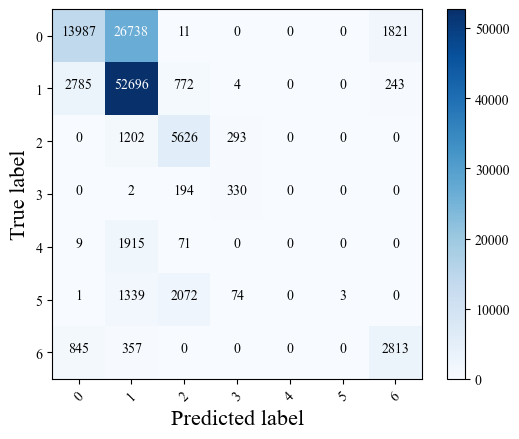

In [ ]:
if alg_table[alg_name]:
    # 展示模型的混淆矩阵及其数据
    predicted = predict(w, x_test).squeeze()
    plot_lr_all_info(np.argmax(y_test, axis=0), 
                     predicted, 
                     classes=list(range(cls_nums)),
                     )
    

# 5 KQ-DADAM-Push-Sum模型训练

## 5.1 设置优化器初始参数

In [ ]:

# 初始步长

step_init = 1
# eig返回元组，第一为特征值，第二为特征向量
# step_init=1-np.sort(np.linalg.eig(net)[0])[1]  # 选取第二特征值
beta1 = 0.9
beta2 = 0.999
beta3 = 0.9
G0=1e-3
beta1t_lambda=0.9

In [ ]:
# 批量大小
batch_size = 1000
sample_nums_per_agent=math.ceil(nums/agents_num)

In [ ]:
beta1t_lambda=0.9

## 5.2 初始化优化器

In [ ]:
w_node = np.zeros((agents_num, dims, cls_nums if cls_nums > 2 else 1))
x_node = np.zeros((agents_num, dims, cls_nums if cls_nums > 2 else 1))
x_prev_node=np.zeros((agents_num, dims, cls_nums if cls_nums > 2 else 1))
# x_hat_node 初始化为0
quant_x_node=np.zeros((agents_num, dims, cls_nums if cls_nums > 2 else 1))
quant_x_prev_node=np.zeros((agents_num, dims, cls_nums if cls_nums > 2 else 1))
m_node = np.zeros((agents_num, dims, cls_nums if cls_nums > 2 else 1))
v_node = np.zeros((agents_num, dims, cls_nums if cls_nums > 2 else 1))
m_hat_node = np.zeros((agents_num, dims, cls_nums if cls_nums > 2 else 1))
v_hat_node = np.zeros((agents_num, dims, cls_nums if cls_nums > 2 else 1))
v_bar_node = np.zeros((agents_num, dims, cls_nums if cls_nums > 2 else 1))
v_bar_prev_node = G0**2 * np.ones((agents_num, dims, cls_nums if cls_nums > 2 else 1))


x_hat_node=np.zeros((agents_num, dims, cls_nums if cls_nums > 2 else 1))
x_hat_prev_node=np.zeros((agents_num, dims, cls_nums if cls_nums > 2 else 1))
# y_node 初始化为1
y_node=np.ones((agents_num, dims, cls_nums if cls_nums > 2 else 1))
y_prev_node=np.ones((agents_num, dims, cls_nums if cls_nums > 2 else 1))

z_node=np.zeros((agents_num, dims, cls_nums if cls_nums > 2 else 1))


In [ ]:
for ii in range(agents_num):
    w_node[ii] = w_init.copy()
    quant_x_node[ii]=quantizer(w_init,1)

    x_node[ii]=w_init.copy()
    x_prev_node[ii]=w_init.copy()

    z_node[ii]=w_init.copy()

In [ ]:
batch_nums = math.ceil(nums / (batch_size*agents_num))

In [ ]:
total_iter = 0

## 5.3 模型训练

In [ ]:
# 算法名称
alg_name="kq-dadam-ps"

if alg_table[alg_name]:
    
    alg_label = f"method_{alg_name}_step_{step_init:.2f}_bs_{batch_size}_ktpow_{kt_pow}"
    # 初始化 训练过程记录
    training_recorder.init_alg_model(alg_label)
    # 记录初始状态
    training_recorder.auto_cal_and_append(alg_label,np.mean(w_node,axis=0),w_opt,loss_fn,get_scores,predict,x_train,y_train,x_test,y_test)


    pbar=tqdm(total=epoch_num)
    for i in trange(epoch_num):
        pbar.update()
        # _,net = get_strongly_connected_directed_row_column_stochastic_matrix(agents_num)
        for j in range(batch_nums):
            total_iter = total_iter + 1
            kt=min(math.ceil((i+1)**kt_pow),1)
            beta1t=get_beta1t(beta1,total_iter,lambda_val=beta1t_lambda)
            step=get_stepsize(step_init,total_iter,method="decay-sq")
            for ii in range(agents_num):
                start = ii * sample_nums_per_agent
                end = min((ii + 1) * sample_nums_per_agent, nums)
                # 获取数据切片
                x_data = x_train[:, start:end]
                y_data = y_train[:, start:end]

                # 生成随机数
                random_index=np.random.randint(0,end-start,size=batch_size)
                
                linear_index=list(range(0,end-start))[batch_size*j:batch_size*(j+1)]
                x_data=x_data[:,random_index]
                y_data=y_data[:,random_index]
                # 对权重进行量化
                w_consen_node = np.zeros(w_init.shape)
                for jj in range(agents_num):
                    w_consen_node = w_consen_node + net[ii,jj] * stochastic_k_level_quantizer(x_prev_node[jj],kt=kt,use_quantize=True)
                w_node[ii] = w_consen_node

                y_consen_node=np.zeros(w_init.shape)
                for jj in range(agents_num):
                    y_consen_node=y_consen_node+net[ii,jj]*y_prev_node[jj]
                y_node[ii]=y_consen_node
                y_prev_node[ii]=y_node[ii].copy()

                z_node[ii]=w_node[ii]/y_node[ii]
                
               # 梯度下降函数更新W权重
                grad = grad_fn(x_data, y_data, z_node[ii].squeeze())
                # 加入DADAM
                m_node[ii] = (
                    beta1t * m_node[ii] + (1 - beta1t) * grad
                )  # update biased first moment estimate
                v_node[ii] = beta2 * v_node[ii] + (1 - beta2) * np.power(
                    grad, 2
                )  # update biased second raw moment estimate

                m_hat_node[ii] = m_node[ii] / (
                    1 - beta1t**total_iter
                )  # compute bias-corrected fist moment estimate
                v_hat_node[ii] = v_node[ii] / (
                    1 - beta2**total_iter
                )  # compute bias-corrected second raw moment estimate

                v_bar_node[ii] = beta3 * v_bar_prev_node[ii] + (1 - beta3) * np.where(
                v_hat_node[ii]>v_bar_prev_node[ii], v_hat_node[ii],v_bar_prev_node[ii])  # normalize second raw moment

                v_bar_prev_node[ii]=v_bar_node[ii].copy()       

    
                if ii==1:
                    record_w.append(np.average(w_node[ii]))
                if ii==1:
                    record_y.append(np.average(y_node[ii]))

                x_node[ii] = w_node[ii] - step * m_hat_node[ii] / (
                np.sqrt(v_bar_node[ii] )+ epsilon
                )
                x_prev_node[ii]=x_node[ii].copy()

            w = np.mean(x_node,axis=0)
        

        # 记录训练过程各参数
        training_recorder.auto_cal_and_append(alg_label,w,w_opt,loss_fn,get_scores,predict,x_train,y_train,x_test,y_test)
        pbar.set_postfix(loss=training_recorder.get_data_by_measure_and_alg_label('loss',alg_label)[i],
                         accu=training_recorder.get_data_by_measure_and_alg_label('accu',alg_label)[i],
                         gen=i+1)
        



## 5.4 展示结果

In [ ]:
if alg_table[alg_name]:
    # 展示模型的混淆矩阵及其数据
    predicted = predict(w, x_test).squeeze()
    plot_lr_all_info(np.argmax(y_test, axis=0), 
                     predicted, 
                     classes=list(range(cls_nums)),
                     use_CN=False)

# 6 Q-DADAM-Push-Sum模型训练

In [ ]:

# 初始步长

step_init = 1
# eig返回元组，第一为特征值，第二为特征向量
# step_init=1-np.sort(np.linalg.eig(net)[0])[1]  # 选取第二特征值
beta1 = 0.9
beta2 = 0.999
beta3 = 0.9
G0=1e-3
beta1t_lambda=0.9

In [ ]:
# 批量大小
batch_size = 1000
sample_nums_per_agent=math.ceil(nums/agents_num)

In [ ]:
beta1t_lambda=0.9

## 6.2 初始化优化器

In [ ]:
w_node = np.zeros((agents_num, dims, cls_nums if cls_nums > 2 else 1))
x_node = np.zeros((agents_num, dims, cls_nums if cls_nums > 2 else 1))
x_prev_node=np.zeros((agents_num, dims, cls_nums if cls_nums > 2 else 1))
# x_hat_node 初始化为0
quant_x_node=np.zeros((agents_num, dims, cls_nums if cls_nums > 2 else 1))
quant_x_prev_node=np.zeros((agents_num, dims, cls_nums if cls_nums > 2 else 1))
m_node = np.zeros((agents_num, dims, cls_nums if cls_nums > 2 else 1))
v_node = np.zeros((agents_num, dims, cls_nums if cls_nums > 2 else 1))
m_hat_node = np.zeros((agents_num, dims, cls_nums if cls_nums > 2 else 1))
v_hat_node = np.zeros((agents_num, dims, cls_nums if cls_nums > 2 else 1))
v_bar_node = np.zeros((agents_num, dims, cls_nums if cls_nums > 2 else 1))
v_bar_prev_node = G0**2 * np.ones((agents_num, dims, cls_nums if cls_nums > 2 else 1))


x_hat_node=np.zeros((agents_num, dims, cls_nums if cls_nums > 2 else 1))
x_hat_prev_node=np.zeros((agents_num, dims, cls_nums if cls_nums > 2 else 1))
# y_node 初始化为1
y_node=np.ones((agents_num, dims, cls_nums if cls_nums > 2 else 1))
y_prev_node=np.ones((agents_num, dims, cls_nums if cls_nums > 2 else 1))

z_node=np.zeros((agents_num, dims, cls_nums if cls_nums > 2 else 1))


In [ ]:
for ii in range(agents_num):
    w_node[ii] = w_init.copy()
    quant_x_node[ii]=quantizer(w_init,1)

    x_node[ii]=w_init.copy()
    x_prev_node[ii]=w_init.copy()

    z_node[ii]=w_init.copy()

In [ ]:
batch_nums = math.ceil(nums / (batch_size*agents_num))

In [ ]:
total_iter = 0

## 6.3 模型训练

In [ ]:
# 算法名称
alg_name="q-dadam-ps"

if alg_table[alg_name]:
    
    alg_label = f"method_{alg_name}_step_{step_init:.2f}_bs_{batch_size}_ktpow_{kt_pow}"
    # 初始化 训练过程记录
    training_recorder.init_alg_model(alg_label)
    # 记录初始状态
    training_recorder.auto_cal_and_append(alg_label,np.mean(w_node,axis=0),w_opt,loss_fn,get_scores,predict,x_train,y_train,x_test,y_test)


    pbar=tqdm(total=epoch_num)
    for i in trange(epoch_num):
        pbar.update()
        # _,net = get_strongly_connected_directed_row_column_stochastic_matrix(agents_num)
        for j in range(batch_nums):
            total_iter = total_iter + 1
            kt=math.ceil((i+1)**kt_pow)
            beta1t=get_beta1t(beta1,total_iter,lambda_val=beta1t_lambda)
            step=get_stepsize(step_init,total_iter,method="decay-sq")
            for ii in range(agents_num):
                start = ii * sample_nums_per_agent
                end = min((ii + 1) * sample_nums_per_agent, nums)
                # 获取数据切片
                x_data = x_train[:, start:end]
                y_data = y_train[:, start:end]

                # 生成随机数
                random_index=np.random.randint(0,end-start,size=batch_size)
                
                linear_index=list(range(0,end-start))[batch_size*j:batch_size*(j+1)]
                x_data=x_data[:,random_index]
                y_data=y_data[:,random_index]
                # 对权重进行量化
                w_consen_node = np.zeros(w_init.shape)
                for jj in range(agents_num):
                    w_consen_node = w_consen_node + net[ii,jj] * quantizer(x_prev_node[jj],kt=kt,use_quantize=True)
                w_node[ii] = w_consen_node

                y_consen_node=np.zeros(w_init.shape)
                for jj in range(agents_num):
                    y_consen_node=y_consen_node+net[ii,jj]*y_prev_node[jj]
                y_node[ii]=y_consen_node
                y_prev_node[ii]=y_node[ii].copy()

                z_node[ii]=w_node[ii]/y_node[ii]
                
               # 梯度下降函数更新W权重
                grad = grad_fn(x_data, y_data, z_node[ii].squeeze())
                # 加入DADAM
                m_node[ii] = (
                    beta1t * m_node[ii] + (1 - beta1t) * grad
                )  # update biased first moment estimate
                v_node[ii] = beta2 * v_node[ii] + (1 - beta2) * np.power(
                    grad, 2
                )  # update biased second raw moment estimate

                m_hat_node[ii] = m_node[ii] / (
                    1 - beta1t**total_iter
                )  # compute bias-corrected fist moment estimate
                v_hat_node[ii] = v_node[ii] / (
                    1 - beta2**total_iter
                )  # compute bias-corrected second raw moment estimate

                v_bar_node[ii] = beta3 * v_bar_prev_node[ii] + (1 - beta3) * np.where(
                v_hat_node[ii]>v_bar_prev_node[ii], v_hat_node[ii],v_bar_prev_node[ii])  # normalize second raw moment

                v_bar_prev_node[ii]=v_bar_node[ii].copy()       

    
                if ii==1:
                    record_w.append(np.average(w_node[ii]))
                if ii==1:
                    record_y.append(np.average(y_node[ii]))

                x_node[ii] = w_node[ii] - step * m_hat_node[ii] / (
                np.sqrt(v_bar_node[ii] )+ epsilon
                )
                x_prev_node[ii]=x_node[ii].copy()

            w = np.mean(x_node,axis=0)
         

        # 记录训练过程各参数
        training_recorder.auto_cal_and_append(alg_label,w,w_opt,loss_fn,get_scores,predict,x_train,y_train,x_test,y_test)
        pbar.set_postfix(loss=training_recorder.get_data_by_measure_and_alg_label('loss',alg_label)[i],
                         accu=training_recorder.get_data_by_measure_and_alg_label('accu',alg_label)[i],
                         gen=i+1)
        


100%|██████████| 300/300 [05:20<00:00,  1.07s/it] accu=0.671, gen=300, loss=3.34]


## 6.4 展示结果

              precision    recall  f1-score   support

           0  0.82009768 0.21305543 0.33823886     42557
           1  0.60258599 0.95600000 0.73922415     56500
           2  0.78791064 0.42100829 0.54878272      7121
           3  0.31059984 0.71863118 0.43373494       526
           4  0.25000000 0.00852130 0.01648085      1995
           5  0.37924628 0.40957294 0.39382665      3489
           6  0.45444979 0.75292653 0.56679479      4015

    accuracy                      0.61036290    116203
   macro avg  0.51498432 0.49710224 0.43386899    116203
weighted avg  0.67440297 0.61036290 0.55058169    116203

Confusion matrix, without normalization
[[ 9067 30226     2     0     7     6  3249]
 [ 1458 54014   219     2    41   386   380]
 [    0  1628  2998   643     3  1849     0]
 [    0     4    76   378     0    68     0]
 [    9  1934     5     0    17    30     0]
 [    1  1360   505   194     0  1429     0]
 [  521   471     0     0     0     0  3023]]


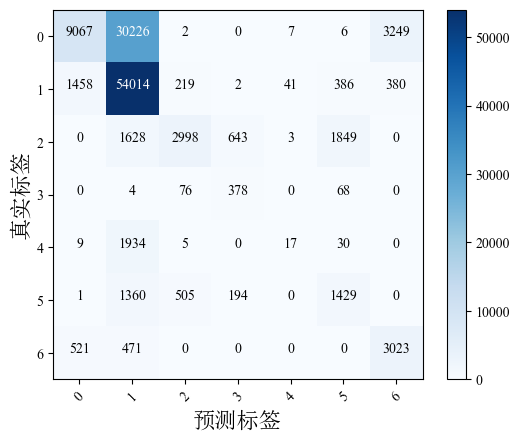

In [ ]:
if alg_table[alg_name]:
    # 展示模型的混淆矩阵及其数据
    predicted = predict(w, x_test).squeeze()
    plot_lr_all_info(np.argmax(y_test, axis=0), 
                     predicted, 
                     classes=list(range(cls_nums)),
                     save_path=f"./figs/multi_lr_{alg_name}_{data_name}.png",
                     use_CN=True)

              precision    recall  f1-score   support

           0  0.82009768 0.21305543 0.33823886     42557
           1  0.60258599 0.95600000 0.73922415     56500
           2  0.78791064 0.42100829 0.54878272      7121
           3  0.31059984 0.71863118 0.43373494       526
           4  0.25000000 0.00852130 0.01648085      1995
           5  0.37924628 0.40957294 0.39382665      3489
           6  0.45444979 0.75292653 0.56679479      4015

    accuracy                      0.61036290    116203
   macro avg  0.51498432 0.49710224 0.43386899    116203
weighted avg  0.67440297 0.61036290 0.55058169    116203

Confusion matrix, without normalization
[[ 9067 30226     2     0     7     6  3249]
 [ 1458 54014   219     2    41   386   380]
 [    0  1628  2998   643     3  1849     0]
 [    0     4    76   378     0    68     0]
 [    9  1934     5     0    17    30     0]
 [    1  1360   505   194     0  1429     0]
 [  521   471     0     0     0     0  3023]]


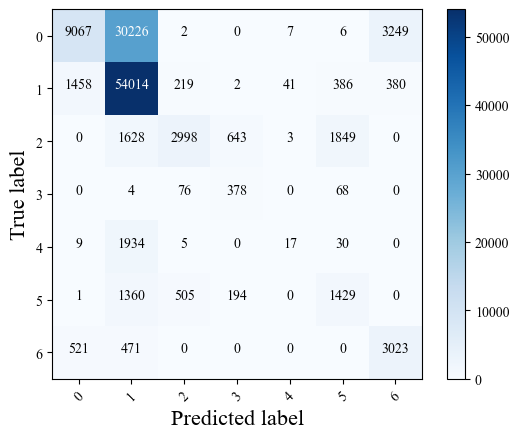

In [ ]:
if alg_table[alg_name]:
    plot_lr_all_info(np.argmax(y_test, axis=0), 
                     predicted, 
                     classes=list(range(cls_nums)),
                     save_path=f"./figs_en/multi_lr_{alg_name}_{data_name}_en.pdf",
                     use_CN=False)

# 数据处理

In [ ]:
# 导出所有数据，并绘制到tensorboard
recorded_data=training_recorder.get_all_data_for_writer_scalars()
for measure,recorder_ls in recorded_data.items():
    epoch=0
    for d in recorder_ls:
        writer.add_scalars(measure,d,epoch)
        epoch=epoch+1

In [ ]:
recorded_data.keys()

dict_keys(['lossopt', 'loss', 'f1', 'accu', 'recall', 'regret'])

In [ ]:
record_accuracy_dict = {
    "q-pdq": [],
    "q-dadam-ps": [],
    "dadam-ps": []
}

for item in recorded_data["accu"]:
    for key, value in item.items():
        # 解析键名结构 method_{method}_step_...
        method_type = key.split("_")[1]  # 提取核心方法名
        if method_type in record_accuracy_dict:
            record_accuracy_dict[method_type].append(value)

In [ ]:
record_loss_dict = {
    "q-pdq": [],
    "q-dadam-ps": [],
    "dadam-ps": []
}

for item in recorded_data["loss"]:
    for key, value in item.items():
        # 解析键名结构 method_{method}_step_...
        method_type = key.split("_")[1]  # 提取核心方法名
        if method_type in record_loss_dict:
            record_loss_dict[method_type].append(value)

In [ ]:
def smoothing(x ,smooth=0.99):
    """
    The smoothing function takes in a list of numbers and returns the same list with each number replaced by
    the average of itself and all previous numbers. The optional argument smooth is used to determine how much weight
    to give to the previous values, with 0 being no weight at all (i.e., just return the original array) and 1 giving
    equal weight to all values.

    :param x: Pass the data to be smoothed
    :param smooth: Control the amount of smoothing
    :return: A new array with the smoothed values
    :doc-author: Trelent
    """
    x = x.copy()
    weight = smooth
    for i in range(1 ,len(x)):
        x[i] = (x[ i -1] * weight + x[i]) / (weight + 1)
        weight = (weight + 1) * smooth
    return x

### 绘制中文结果

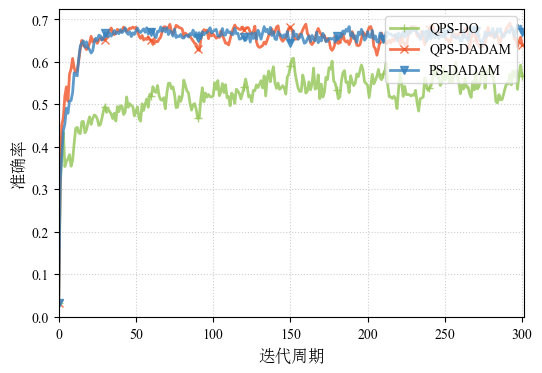

In [ ]:
color_ls = ["93c555","f05326","3682be","45a776"]
marker_ls=["+", "x","v", "^", "<", ">", "1",]

name_dict={
    "q-pdq":"QPS-DO",
    "q-dadam-ps":"QPS-DADAM",  # PS-QDADAM: Push-Sum based Quantized Distributed ADAM
    "dadam-ps":"PS-DADAM",
    "kq-dadam-ps":"KQPS-DADAM",
}

fig, ax1 = plt.subplots(
        figsize=(6, 4),
        sharex=True,
    )
    
# ------ 子图1：真实信号观测 ------
for idx,key in enumerate(record_accuracy_dict):
    ls=record_accuracy_dict[key]
    measure_data_len=len(ls)
    # marker个数
    marker_num=10
    ax1.plot( smoothing(ls,smooth=0.6),  linewidth=2, 
             color='#'+color_ls[idx],
             marker=f"{marker_ls[idx]}",
             markevery=int(measure_data_len / marker_num),
                alpha=0.8, label=name_dict[key])
ax1.set_xlabel('迭代周期', fontsize=12, fontproperties=chinese_font)
ax1.set_ylabel('准确率', fontsize=12, fontproperties=chinese_font)
ax1.set_xlim(0, int(measure_data_len*1.002))
ax1.legend(loc='upper right')
ax1.grid(True, linestyle=':', alpha=0.6)

ext="png"
fig.savefig(
    fname=f"figs/accu-compare-q-dadam-ps-muilt-lr-{data_name}.png",
    format=ext,
    bbox_inches='tight',
    dpi=300,  # ✅ 分辨率倍增
    pad_inches=0.1,  # ✅ 边界留白
    facecolor='auto',  # ✅ 自动背景填充
    metadata={'Creator': ''},  # ✅ 清除元数据
    quality=95 if ext == 'jpg' else None  # ✅ 格式定制
)


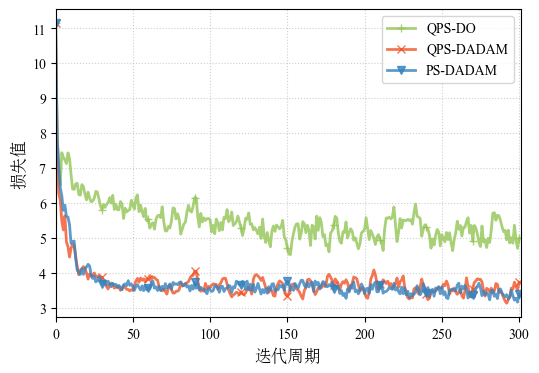

In [ ]:
color_ls = ["93c555","f05326","3682be","45a776"]
marker_ls=["+", "x","v", "^", "<", ">", "1",]

name_dict={
    "q-pdq":"QPS-DO",
    "q-dadam-ps":"QPS-DADAM",  # PS-QDADAM: Push-Sum based Quantized Distributed ADAM
    "dadam-ps":"PS-DADAM",
    "kq-dadam-ps":"KQPS-DADAM",
}

fig, ax1 = plt.subplots(
        figsize=(6, 4),
        sharex=True,
    )
    
# ------ 子图1：真实信号观测 ------
for idx,key in enumerate(record_loss_dict):
    ls=record_loss_dict[key]
    measure_data_len=len(ls)
    # marker个数
    marker_num=10
    ax1.plot( smoothing(ls,smooth=0.6),  linewidth=2, 
             color='#'+color_ls[idx],
             marker=f"{marker_ls[idx]}",
             markevery=int(measure_data_len / marker_num),
                alpha=0.8, label=name_dict[key])
ax1.set_xlabel('迭代周期', fontsize=12, fontproperties=chinese_font)
ax1.set_ylabel('损失值', fontsize=12 ,fontproperties=chinese_font)
ax1.set_xlim(0, int(measure_data_len*1.002))
ax1.legend(loc='upper right')
ax1.grid(True, linestyle=':', alpha=0.6)

ext="png"
fig.savefig(
    fname=f"figs/loss-compare-q-dadam-ps-muilt-lr-{data_name}.png",
    format=ext,
    bbox_inches='tight',
    dpi=300,  # ✅ 分辨率倍增
    pad_inches=0.1,  # ✅ 边界留白
    facecolor='auto',  # ✅ 自动背景填充
    metadata={'Creator': ''},  # ✅ 清除元数据
    quality=95 if ext == 'jpg' else None  # ✅ 格式定制
)


### 绘制英文结果

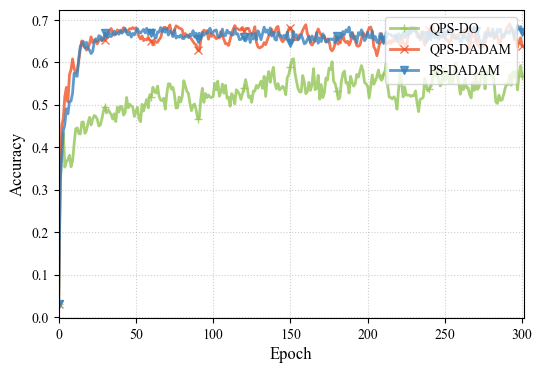

In [ ]:

color_ls = ["93c555","f05326","3682be","45a776"]
marker_ls=["+", "x","v", "^", "<", ">", "1",]

name_dict={
    "q-pdq":"QPS-DO",
    "q-dadam-ps":"QPS-DADAM",  # PS-QDADAM: Push-Sum based Quantized Distributed ADAM
    "dadam-ps":"PS-DADAM",
    "kq-dadam-ps":"KQPS-DADAM",
}

fig, ax1 = plt.subplots(
        figsize=(6, 4),
        sharex=True,
    )
    
# ------ 子图1：真实信号观测 ------
for idx,key in enumerate(record_accuracy_dict):
    ls=record_accuracy_dict[key]
    measure_data_len=len(ls)
    # marker个数
    marker_num=10
    ax1.plot( smoothing(ls,smooth=0.6),  linewidth=2, 
             color='#'+color_ls[idx],
             marker=f"{marker_ls[idx]}",
             markevery=int(measure_data_len / marker_num),
                alpha=0.8, label=name_dict[key])
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Accuracy', fontsize=12)
ax1.set_xlim(0, int(measure_data_len*1.002))
ax1.legend(loc='upper right')
ax1.grid(True, linestyle=':', alpha=0.6)

ext="pdf"
fig.savefig(
    fname=f"figs_en/accu-compare-q-dadam-ps-muilt-lr-{data_name}_en.{ext}",
    format=ext,
    bbox_inches='tight',
    dpi=300,  # ✅ 分辨率倍增
    pad_inches=0.1,  # ✅ 边界留白
    facecolor='auto',  # ✅ 自动背景填充
    metadata={'Creator': ''},  # ✅ 清除元数据
    quality=95 if ext == 'jpg' else None  # ✅ 格式定制
)


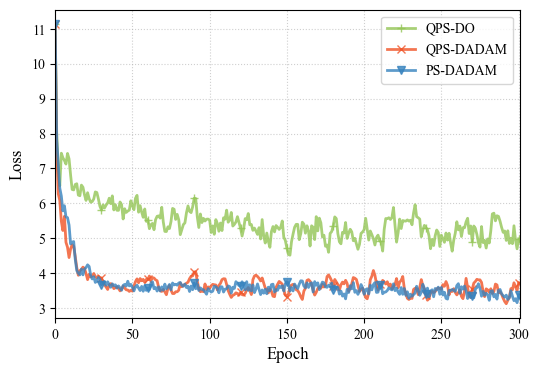

In [ ]:
color_ls = ["93c555","f05326","3682be","45a776"]
marker_ls=["+", "x","v", "^", "<", ">", "1",]

name_dict={
    "q-pdq":"QPS-DO",
    "q-dadam-ps":"QPS-DADAM",  # PS-QDADAM: Push-Sum based Quantized Distributed ADAM
    "dadam-ps":"PS-DADAM",
    "kq-dadam-ps":"KQPS-DADAM",
}

fig, ax1 = plt.subplots(
        figsize=(6, 4),
        sharex=True,
    )
    
# ------ 子图1：真实信号观测 ------
for idx,key in enumerate(record_loss_dict):
    ls=record_loss_dict[key]
    measure_data_len=len(ls)
    # marker个数
    marker_num=10
    ax1.plot( smoothing(ls,smooth=0.6),  linewidth=2, 
             color='#'+color_ls[idx],
             marker=f"{marker_ls[idx]}",
             markevery=int(measure_data_len / marker_num),
                alpha=0.8, label=name_dict[key])
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Loss', fontsize=12 )
ax1.set_xlim(0, int(measure_data_len*1.002))
ax1.legend(loc='upper right')
ax1.grid(True, linestyle=':', alpha=0.6)

ext="pdf"
fig.savefig(
    fname=f"figs_en/loss-compare-q-dadam-ps-muilt-lr-{data_name}_en.{ext}",
    format=ext,
    bbox_inches='tight',
    dpi=300,  # ✅ 分辨率倍增
    pad_inches=0.1,  # ✅ 边界留白
    facecolor='auto',  # ✅ 自动背景填充
    metadata={'Creator': ''},  # ✅ 清除元数据
    quality=95 if ext == 'jpg' else None  # ✅ 格式定制
)
